# Learning high-resolution data from low-resolution

This is an example notebook showing how to use the `pes_to_spec` infrastructure in this package.

We start by importing some modules. The key module here is called `pes_to_spec`.

In [1]:
import sys
# add the pes_to_spec main directory
# (change this depending on where you started the notebook if needed, or comment it out if you have done pip install in pes_to_spec)
sys.path.append('..')

# you meay need to do pip install matplotlib seaborn extra_data for this notebook, additionally
# for this notebook the following packages are needed:
# pip install "numpy>=1.21" "scipy>=1.6" "scikit-learn>=1.2.0" torch torchbnn  matplotlib seaborn extra_data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec 
import seaborn as sns

from extra_data import open_run, by_id
from itertools import product
from pes_to_spec.model import Model, matching_ids

from typing import Any, Dict

# Input data

Read data from two runs. One shall be used for training the model. The second one is used for testing it.
Note that the data in the training run must be large enough, compared to the number of model parameters.

Only the SPEC, PES and XGM data is used for training, while only the PES and XGM data is needed for testing.
However, more data is collected here to validate the results.

In [3]:
run = open_run(proposal=3384, run=2)
run_test = open_run(proposal=3384, run=3)

# useful names to avoid repeating it all over the notebook, in case they ever change
spec_name = "SA3_XTD10_SPECT/MDL/SPECTROMETER_SQS_NAVITAR:output"
pes_name = "SA3_XTD10_PES/ADC/1:network"
xgm_name = "SA3_XTD10_XGM/XGM/DOOCS:output"

pres_name = "SA3_XTD10_PES/GAUGE/G30310F"
volt_name = "SA3_XTD10_PES/MDL/DAQ_MPOD"

# PES channels
channels = [f"channel_{i}_{l}" for i, l in product(range(1, 5), ["A", "B", "C", "D"])]

def get_gas(run) -> str:
    """Get gas in chamber for logging."""
    gas_sources = [
                  "SA3_XTD10_PES/DCTRL/V30300S_NITROGEN",
                  "SA3_XTD10_PES/DCTRL/V30310S_NEON",
                  "SA3_XTD10_PES/DCTRL/V30320S_KRYPTON",
                  "SA3_XTD10_PES/DCTRL/V30330S_XENON",
              ]
    gas_active = list()
    for gas in gas_sources:
        # check if this gas source is interlocked
        if gas in run.all_sources and run[gas, "interlock.AActionState.value"].ndarray().sum() == 0:
            # it is not, so this gas was used
            gas_active += [gas.split("/")[-1].split("_")[-1]]
    gas = "_".join(gas_active)
    return gas

def get_tids(run, need_spec:bool=True) -> np.ndarray:
    """Get which train IDs contain all necessary inputs for training."""
    spec_tid = run[spec_name, "data.trainId"].ndarray()
    pes_tid = run[pes_name, "digitizers.trainId"].ndarray()
    xgm_tid = run[xgm_name, "data.trainId"].ndarray()

    # match tids to be sure we have all inputs:
    tids = matching_ids(spec_tid, pes_tid, xgm_tid)
    return tids

def get_data(run, tids) -> Dict[str, Any]:
    """Get all relevant data."""
    data = dict()
    data["int"] = run[xgm_name, "data.intensitySa3TD"].select_trains(by_id[tids]).ndarray()[:, 0][:, np.newaxis]
    data["pressure"] = run[pres_name, "value"].select_trains(by_id[tids]).ndarray()
    data["voltage"] = run[volt_name, "u212.value"].select_trains(by_id[tids]).ndarray()
    data["energy"] = run[spec_name, "data.photonEnergy"].select_trains(by_id[tids]).ndarray()
    data["spec"] = run[spec_name, "data.intensityDistribution"].select_trains(by_id[tids]).ndarray()
    data["pes"] = {ch: run[pes_name,
                           f"digitizers.{ch}.raw.samples"].select_trains(by_id[tids]).ndarray()
                    for ch in channels}
    data["gas"] = get_gas(run)
    return data


In [4]:

# get the matched train IDs
tids = get_tids(run)

# we don't need the spec for testing in reality,
# but it is nice to plot it in the test run too,
# to check that this works during validation
test_tids = get_tids(run_test, need_spec=True)

# get the data
data = get_data(run, tids)
data_test = get_data(run_test, test_tids)


Now the `data` and `data_test` dictionaries contain the necessary information about the training and test runs.
The code above also selected only entries with train IDs on which at least SPEC, PES and XGM were present.

Note that for training, it is assumed that only one pulse is present. For testing there is no such requirement.

First output some general information about the conditions of the measurement device.

In [5]:
print(f"Gas in training: {data['gas']}")
print(f"Gas in testing: {data_test['gas']}")

Gas in training: NEON
Gas in testing: NEON


In [6]:
print(f"Voltage in training: {np.mean(data['voltage']):0.2f} +/- {np.std(data['voltage']):0.2f}")
print(f"Voltage in testing: {np.mean(data_test['voltage']):0.2f} +/- {np.std(data_test['voltage']):0.2f}")

Voltage in training: -15.36 +/- 0.01
Voltage in testing: -15.36 +/- 0.00


In [7]:
print(f"Pressure in training: {np.mean(data['pressure']):0.2e} +/- {np.std(data['pressure']):0.2e}")
print(f"Pressure in testing: {np.mean(data_test['pressure']):0.2e} +/- {np.std(data_test['pressure']):0.2e}")

Pressure in training: 3.73e-07 +/- 1.11e-08
Pressure in testing: 3.74e-07 +/- 8.43e-09


Now we will actually train the model. We do that by creating a `Model` object (from `pes_to_spec`) and calling the `fit` function.
The `fit` function requires the PES intensity, the SPEC intensity, the energy axis from SPEC (stored as a reference only), as well as the energy measured in the XGM (which has better resolution than the integral of the PES).

In [8]:
# this is the main object holding all
# information needed for training and prediction
# the default parameters should be sufficient in most times
model = Model()

# this trains the model
# the first parameter is expected to be a dictionary with the channel name as a key
model.fit(data['pes'],
          data['spec'],
          data['energy'],
          pulse_energy=data['int'])

# save it for later usage:
model.save("model.joblib")

# load a model (you can start from here if working on an existing model)
model = Model.load("model.joblib")

# and use it to map a low-resolution spectrum to a high-resolution one
# as before, the low_resolution_raw_data refers to a dictionary mapping the channel name
# in the format "channel_[1-4]_[A-D]" to the 2D numpy array with shape (number_of_train_IDs, features)
# all names and shapes must match the format in training, except for the number_of_train_IDs, which may vary
pred = model.predict(data['pes'], pulse_energy=data['int'])


Fitting PCA on low-resolution data.
Fitting PCA on high-resolution data.
Fitting outlier detection
Fitting model.
Calculate PCA unc. on high-resolution data.
Calculate transfer function
Calculate PCA on channel_1_A
Calculate PCA on channel_1_B
Calculate PCA on channel_1_C
Calculate PCA on channel_1_D
Calculate PCA on channel_2_A
Calculate PCA on channel_2_B
Calculate PCA on channel_2_C
Calculate PCA on channel_2_D
Calculate PCA on channel_3_A
Calculate PCA on channel_3_B
Calculate PCA on channel_3_C
Calculate PCA on channel_3_D
Calculate PCA on channel_4_A
Calculate PCA on channel_4_B
Calculate PCA on channel_4_C
Calculate PCA on channel_4_D
End of fit.


Now we can try it in the test dataset:

We can predict it in the training data itself, but this is a bit biased, since we used the same information to fit the model.

In [9]:
pred = model.predict(data_test['pes'], pulse_energy=data_test['int'])

# add the references in this array in the same array format, so we can plot them later
pred["energy"] = model.get_energy_values()

# this provides a smoothened version of the high-resolution spectrum, filtering sources of noise
# caused by fluctuations below the spectrometer's resolution
pred['spec_smooth'] = model.preprocess_high_res(data_test['spec'])[:, np.newaxis, :]

Let's try to predict in the independent run in the test dataset. The performance of the model varies a lot if the beam intensity is very different from the training one. To ensure we take a train ID to visualize that is relatively high intensity, we sort the train IDs by XGM intensity and then choose the highest intensity one.
One could try other train IDs.

For train IDs with close to zero beam intensity, there is a relatively larger error, since the training data did not contain any of those samples and the signal-to-noise ratio is relatively high.

In [10]:
# choose train ID of the test dataset by XGM intensity
test_intensity = np.argsort(data_test['int'][:,0])
example_tid = test_intensity[-1]

Now we can actually plot it.

In [11]:
def plot(data):
    """Plot prediction and expectation."""
    fig = plt.figure(figsize=(12, 8))
    gs = GridSpec(1, 1)
    ax = fig.add_subplot(gs[0, 0])
    ax.plot(data["energy"], data["spec_smooth"], c='b', lw=3, label="High-res. measurement (smoothened)")
    ax.plot(data["energy"], data["expected"], c='r', ls='--', lw=3, label="High-res. prediction")
    ax.fill_between(data["energy"], data["expected"] - data["total_unc"], data["expected"] + data["total_unc"], facecolor='gold', alpha=0.5, label="68% unc.")
    ax.legend(frameon=False, borderaxespad=0, loc='upper left')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    Y = np.amax(data["spec_smooth"])
    ax.set(
            xlabel="Photon energy [eV]",
            ylabel="Intensity",
            ylim=(0, 1.3*Y))
    plt.show()

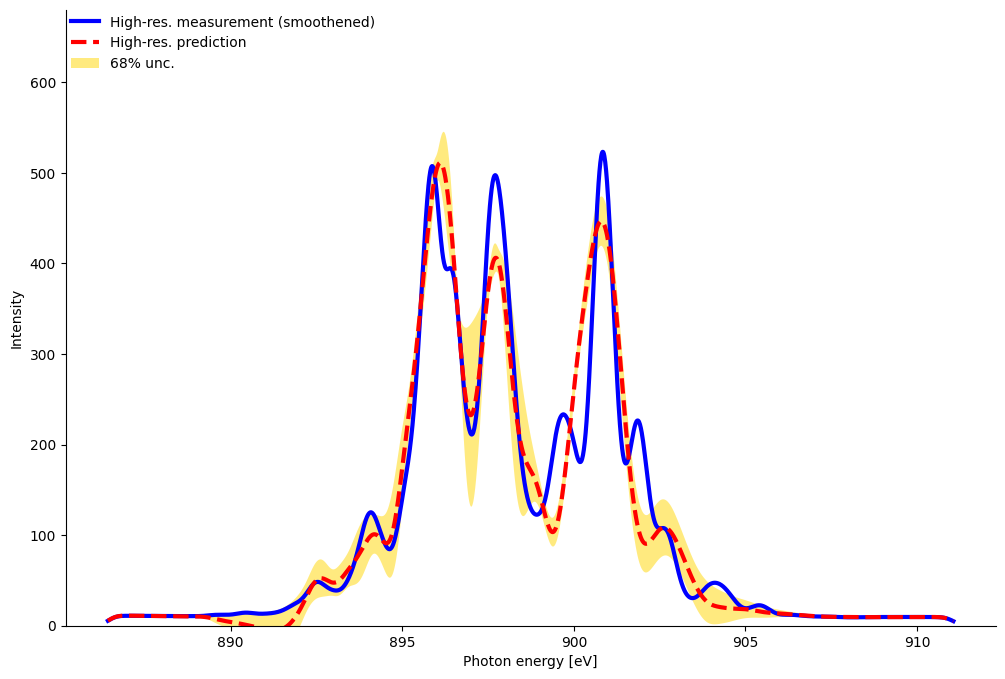

In [12]:
# select the correct train ID for the data to plot
# except for the energy axis, which is always the same
plot({k: v[example_tid, 0, :] if k != "energy" else v
      for k, v in pred.items()
      if k in ["expected", "total_unc", "spec_smooth", "energy"]})